Nathan Deinlein <br>
Ryan Kinney <br>
Chris Roche <br>
Cameron Stewart <br>

# Machine Learning 1 - MiniLab LR and SVM

## Section 1: Create Models

### Logistic Regression

Logistic Regression is a statistical technique for categorizing a binary outcome. For the horse racing data set, we're using predictors such as horse age, rating, and odds to predict whether a horse will win or lose a race.

We began our logistic regression model implementation by importing the necessary libraries and then reading in the data. In Lab 1, once our data was cleaned we saved off a csv file titled "runs_clean.csv" to our GitHub repository. For this lab we read in that file as a starting point since it is already cleaned, all missing data is imputed, and features are formatted appropriately. 

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.metrics import plot_confusion_matrix, roc_auc_score
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
## Read in the cleaned dataframe from Lab 1
url = "https://raw.githubusercontent.com/nedeinlein/Machine_Learning_I/main/runs_clean.csv"
runs_df = pd.read_csv(url, index_col=False)

Logistic regression requires all variables to be numeric. Using the info function we can inspect the data set for objects and determine how to use or not use them.

In [3]:
# Summary statistics of each feature
runs_df.info()
runs_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79423 entries, 0 to 79422
Data columns (total 29 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       79423 non-null  int64  
 1   race_id          79423 non-null  int64  
 2   horse_no         79423 non-null  int64  
 3   horse_id         79423 non-null  int64  
 4   result           79423 non-null  int64  
 5   won              79423 non-null  float64
 6   lengths_behind   79423 non-null  float64
 7   horse_age        79423 non-null  int64  
 8   horse_country    79423 non-null  object 
 9   horse_type       79423 non-null  object 
 10  horse_rating     79423 non-null  int64  
 11  horse_gear       79423 non-null  object 
 12  declared_weight  79423 non-null  float64
 13  actual_weight    79423 non-null  int64  
 14  draw             79423 non-null  int64  
 15  position_sec1    79423 non-null  int64  
 16  position_sec2    79423 non-null  int64  
 17  position_sec

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec2,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,2.00,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,9.00,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,1.00,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,5.00,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,8.75,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154


#### One Hot Encoding

Horse Country and Horse Type are both of type object. These are strings that represent where a horse is from or what type it is (e.g. gelding, mare). For both of these we used one-hot encoding. This allows us to numerically represent them and therefore keep them in the logistic regression model.

First we'll check how many unique types there are in the two variables.

In [4]:
# How many unique values are in horse_type and horse_country
n = runs_df['horse_type'].nunique()
print("Number of horse types: ", n)

n = runs_df['horse_country'].nunique()
print("Number of horse countries: ", n)

Number of horse types:  9
Number of horse countries:  16


Now we will perform the one hot encoding. Note, this will greatly increase the number of columns in our data set since we're now making boolean entries for each of the nine horse types and sixteen countries found in the data set. Therefore we'll add the new columns to a second data set so that we can easily choose whether or not to include the new features in the future.

In [5]:
# Use one hot encoding on non-numerical features
## (Then remove them from the drop code chunk below)
# perform one-hot encoding of the categorical data "embarked"
tmp_df = pd.get_dummies(runs_df.horse_country,prefix='horse_country')
runs_df_onehot = pd.concat((runs_df,tmp_df),axis=1) # add back into the dataframe

tmp_df = pd.get_dummies(runs_df.horse_type,prefix='horse_type')
runs_df_onehot = pd.concat((runs_df_onehot,tmp_df),axis=1) # add back into the dataframe

In addition to the one-hot encoding, we want to add another new feature to the set, this new feature is something we'll try to predict. There are two common types of bets in horse racing: to win and to show. Win is for a horse to finish first and show is for a horse to finish top three. Using the result feature (a horse's finish position from 1 - 14) we can create a new feature for a result of 1, 2, or 3.

#### Create new Show feature to predict

In [6]:
# Add a Show result feature
runs_df['show'] = np.where(runs_df['result'] <= 3, 1, 0)
runs_df_onehot['show'] = np.where(runs_df['result'] <= 3, 1, 0)

runs_df.head(10)

,Unnamed: 0,race_id,horse_no,horse_id,result,won,lengths_behind,horse_age,horse_country,horse_type,...,behind_sec3,time1,time2,time3,finish_time,win_odds,place_odds,trainer_id,jockey_id,show
0,0,0,1,3917,10,0.0,8.00,3,AUS,Gelding,...,1.50,13.85,21.59,23.86,83.92,9.7,3.7,118,2,0
1,1,0,2,2157,8,0.0,5.75,3,NZ,Gelding,...,5.00,14.57,21.99,23.30,83.56,16.0,4.9,164,57,0
2,2,0,3,858,7,0.0,4.75,3,NZ,Gelding,...,0.75,13.69,21.59,23.90,83.40,3.5,1.5,137,18,0
3,3,0,4,1853,9,0.0,6.25,3,SAF,Gelding,...,3.50,14.09,21.83,23.70,83.62,39.0,11.0,80,59,0
4,4,0,5,2796,6,0.0,3.75,3,GB,Gelding,...,4.25,14.77,21.75,23.22,83.24,50.0,14.0,9,154,0
5,5,0,6,3296,3,0.0,1.25,3,NZ,Gelding,...,1.25,14.33,22.03,22.90,82.83,7.0,1.8,54,34,1
6,6,0,7,911,12,0.0,9.50,3,NZ,Gelding,...,0.75,13.53,21.59,23.94,84.15,99.0,28.0,55,149,0
7,7,0,8,2170,1,1.0,0.00,3,AUS,Gelding,...,3.25,14.13,21.87,23.58,82.64,12.0,3.6,47,183,1
8,8,0,9,1730,13,0.0,9.75,3,NZ,Gelding,...,1.25,13.65,21.71,23.90,84.20,38.0,13.0,75,131,0
9,9,0,10,2998,14,0.0,999.00,3,AUS,Mare,...,16.75,15.05,22.31,24.38,92.20,39.0,12.0,109,145,0


Now that we have all the necessary features and the data set is cleaned, we will divide into test and train data sets. We used an 80/20 split: 80% of the data will be used to train the models and the remaining 20% will be used to generate a confusion matrix so that we can evaluate performance and compare various models.

Since the data set contains features not known pre-race (e.g. how many lengths the horse finished behind the winner, lap times, etc.) we will drop those from the training and test sets.

#### Test and Train set split

A total of three test/train data sets were created. One for runs_data without one hot encoding, one for runs_data with one-hot encoding, and one with one-hot encoding but the target is "show" instead of "win". All are derived from the same data set with the same random seed value.

In [7]:
# Split the data and target
# Only use features known pre-race (e.g. not finish time)
# Remove non-numerical features (e.g. horse country) since we performed one hot encoding
runs_data = runs_df.drop(['Unnamed: 0','race_id','horse_id','result','won','show','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id'], axis=1)
runs_target = runs_df['won']
runs_target_show = runs_df['show']

X_train,X_test,Y_train,Y_test = train_test_split(runs_data,runs_target,test_size=0.20,random_state=0)

In [8]:
# Split the data and target
# Only use features known pre-race (e.g. not finish time)
# Remove non-numerical features (e.g. horse country) since we performed one hot encoding
runs_data_onehot = runs_df_onehot.drop(['Unnamed: 0','race_id','horse_id','result','won','show','lengths_behind','horse_country','horse_type','horse_gear','position_sec1','position_sec2','position_sec3','behind_sec1','behind_sec2','behind_sec3','time1','time2','time3','finish_time','trainer_id','jockey_id'], axis=1)
runs_target_onehot = runs_df_onehot['won']
runs_target_show_onehot = runs_df_onehot['show']

X_train_onehot,X_test_onehot,Y_train_onehot,Y_test_onehot = train_test_split(runs_data_onehot,runs_target_onehot,test_size=0.20,random_state=0)
X_train_onehot_show,X_test_onehot_show,Y_train_onehot_show,Y_test_onehot_show = train_test_split(runs_data_onehot,runs_target_show_onehot,test_size=0.20,random_state=0)

#### Logistic Regression Model fitting

Next we created two logistic regression models to predict whether a horse won or lost it's race. For the first model we do not balance the class weights. For the second we do. Note the dramatically higher accuracy for unbalanced classes. For an unbalanced model, it simply predicts a loss for every outcome.

In [9]:
# Use Logistic Regression to predict win/loss - Not Balance
from sklearn.linear_model import LogisticRegression

lr_nobalance = LogisticRegression(penalty='l2', C=1.0, solver='liblinear' )
lr_nobalance.fit(X_train,Y_train)
yhat = lr_nobalance.predict(X_test)

acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

print("Accuracy: ", acc, "%" )
print("AUC: ", auc, "%" )
print("Confusion Matrix: \n",conf)

Accuracy:  0.9207428391564368 %
AUC:  0.5 %
Confusion Matrix: 
 [[14626     0]
 [ 1259     0]]


In [10]:
# Use Logistic Regression to predict win/loss - Class Balance
lr_balance = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_balance.fit(X_train,Y_train)
yhat = lr_balance.predict(X_test)

acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test,yhat)

print("Accuracy: ", acc, "%" )
print("AUC: ", auc, "%" )
print("Confusion Matrix: \n",conf)

Accuracy:  0.5548630783758263 %
AUC:  0.6947558326663638 %
Confusion Matrix: 
 [[7730 6896]
 [ 175 1084]]


#### Parameter tuning: Class Balance

As can be seen below, of the 79423 entries in the data set, only 6360 (8%) won their race. This intuitively makes sense since a horse can finish from first to about fourteenth place depending on the race. When we did not balance the class the logistic regression model selected a loss for every prediction and achieved an accuracy of about 92%, which again intuitively makes sense if 92% of entries are loses.

When we account for this imbalance, or logistic regression model is able to correctly predict whether a horse will win or lose 55.5% of the time. While less accurate than the unbalance model, it is more useful in a real world scenario where we want to make actual picks on which horse will win a race and not just pick every horse to lose all the time.

In [11]:
# How many won, lost values in the data set
item_counts = runs_df['won'].value_counts()
print(item_counts)

0.0    73063
1.0     6360
Name: won, dtype: int64


Next we plotted the confusion matrix for the balanced logistic regression model to help visually interpret our results.

#### Confusion Matrix Heat Map

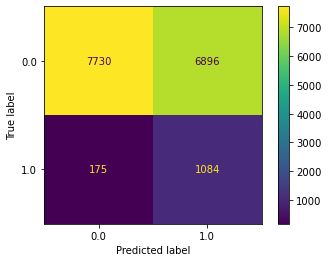

In [12]:
# Plot the confusion matrix
plot_confusion_matrix(lr_balance, X_test, Y_test)

#### Using One Hot Encoding to create a third model

Next we will create a logistic regression model using the one hot encoded features and compare the performance.

In [13]:
lr_onehot = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_onehot.fit(X_train_onehot,Y_train_onehot)
yhat = lr_onehot.predict(X_test_onehot)

acc = mt.accuracy_score(Y_test_onehot,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test_onehot,yhat)
print("Accuracy: ", acc, "%" )
print("AUC: ", auc, "%" )
print("Confusion Matrix: \n",conf)

Accuracy:  0.5562480327352849 %
AUC:  0.6940560984296086 %
Confusion Matrix: 
 [[7756 6870]
 [ 179 1080]]


With the additional features based on horse type and horse country, we increased out performance to 55.6248% at the cost of some added complexity.

#### Compare the three logistic regression models to predict a win

To compare the three models so far:
- Logistic Regression with basic features from the data set: 69.4756% AUC
- Logistic Regression with only odds predictors: 69.6173% AUC
- Logistic Regression with additional one-hot encoded features: 69.4056% AUC

Note the Logistic Regression model with only the odds predictors has the highest AUC score.

#### Create a model to predict if a horse will show

Lastly, we quickly created a logistic regression model using balanced classes and the horse country and type features, but predicted "show" instead of "win". So this model predicts whether a horse will finish first, second, or third. Note it achieved an accuracy of 59.3642% and an AUC of 67.7663%. The model is about 4% more accurate that predicting wins/losses but it has a lower AUC score.

In [14]:
lr_show = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_show.fit(X_train_onehot_show,Y_train_onehot_show)
yhat = lr_show.predict(X_test_onehot_show)

acc = mt.accuracy_score(Y_test_onehot_show,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test_onehot_show,yhat)

print("Accuracy: ", acc, "%" )
print("AUC: ", auc, "%" )
print("Confusion Matrix: \n",conf)

Accuracy:  0.5936418004406673 %
AUC:  0.6776632015385573 %
Confusion Matrix: 
 [[6277 5920]
 [ 535 3153]]


## Section 2: Interpret Feature Importance

### Logistic Regression Model Weight Interpretation

Now that we have determined a class balanced logistic regression model is preferred, we wanted to evaluate how much each predictor contributed to the model. We find the coefficient values for weight and them plot them to visually compare

In [15]:
# Look at the weights
# Source: github/jakemdrew/DataMiningNotebook 4

weights = lr_balance.coef_.T
variable_names = X_train.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

horse_no has weight of -0.002237582389538193
horse_age has weight of 0.0043825330462001055
horse_rating has weight of 0.0007784070799899759
declared_weight has weight of 0.0008365774594610835
actual_weight has weight of 0.0003441433193013598
draw has weight of -0.004366868449994774
win_odds has weight of -0.059762596726509354
place_odds has weight of -0.01298796524530625


#### Logistic Regression Model Feature Weights

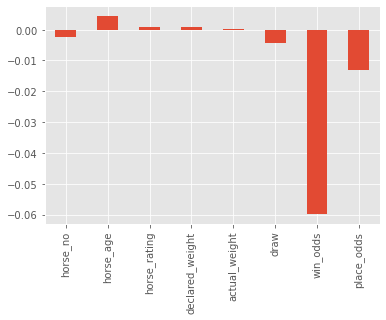

In [16]:
# Plot the weights to compare them
# Source: github/jakemdrew/DataMiningNotebook 4

plt.style.use('ggplot')

weights = pd.Series(lr_balance.coef_[0],index=X_train.columns)
weights.plot(kind='bar')
plt.show()

As can be seen above, odds to win and odds to show are by far the most important predictors. This intuitively makes sense. Lets re-run the logistic regression model again using only those two predictors and compare the performance to the previous model.

In [17]:
# Use Logistic Regression to predict win/loss - Class Balance
X_train_lite = X_train[['win_odds', 'place_odds']]
X_test_lite = X_test[['win_odds', 'place_odds']]


lr_lite = LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', solver='liblinear' )
lr_lite.fit(X_train_lite,Y_train)
yhat = lr_lite.predict(X_test_lite)

acc = mt.accuracy_score(Y_test,yhat)
auc = roc_auc_score(Y_test_onehot,yhat)
conf = mt.confusion_matrix(Y_test,yhat)
print("Accuracy: ", acc, "%" )
print("AUC: ", auc, "%" )
print("Confusion Matrix: \n",conf)

weights = lr_lite.coef_.T
variable_names = X_train.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

Accuracy:  0.5548001259049418 %
AUC:  0.6961734665339135 %
Confusion Matrix: 
 [[7725 6901]
 [ 171 1088]]
horse_no has weight of -0.06032179759892069
horse_age has weight of -0.01311598827744986


For the previous model with many predictors, we achieved an accuracy of 55.4863%. For the model where we only used win odds and place odds, we achieved an almost identical accuracy of 55.48001% with a simpler model.

Finally, we will look at feature importance for the model with that includes horse_type and horse_country.

In [18]:
# We will not visually plot these weights since the plot becomes too cluttered to read
weights = lr_onehot.coef_.T
variable_names = X_train_onehot.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

horse_no has weight of -0.002446828107885964
horse_age has weight of 0.008237314702305914
horse_rating has weight of 0.001068646995946409
declared_weight has weight of 0.0007362207101892282
actual_weight has weight of 0.00022077430655622655
draw has weight of -0.004431892273898282
win_odds has weight of -0.05990890373530979
place_odds has weight of -0.012360194130062712
horse_country_ARG has weight of -0.24137621230555287
horse_country_AUS has weight of 0.12357395636646334
horse_country_BRZ has weight of 0.537105429711514
horse_country_CAN has weight of -0.22738472312136235
horse_country_FR has weight of 0.10045391209080662
horse_country_GB has weight of 0.14795790790218025
horse_country_GER has weight of -0.42909663797510467
horse_country_GR has weight of -1.3715137115841296
horse_country_IRE has weight of 0.04811809292383599
horse_country_ITY has weight of -0.9324660778338693
horse_country_JPN has weight of 0.2872032630538696
horse_country_NZ has weight of 0.14373640535423654
horse_c

## Section 3: Interpret Support Vectors

## Section 4: Model Advantages

### Logistic Regression

Talk about advantages here, such as ability to interpret the feature weights from the coefficients.

### SVM

Talk about advantages here.